# Lab Three — Predicting a Target Market for Protein Powders
### by Eddie Diaz

Dataset Selected: https://dsld.od.nih.gov/

## Preparation and Overview

For this lab, I'll be using the DSLD government database, which contains every supplement sold in the US. For simplicity, I will only download the portion of data for our target subgroup, protein powders sold in the US. Using this subset, I will train a model to predict which target demographic best suits a particular product based on serving size, daily value, and key ingredient. This mix of quantitative and categorical values will enable us to best predict the target demographic. To do this, I will first define a dummy categorical variable based on serving size. These values will be one-hot encoded to designate their respective target demographic in ascending order (low, mid high). The logic behind this process was explained in Lab One. Then, I'll use a predictive linear regression algorithm to obtain weight values for each feature to predict a multi-class target value that nears our "product type," the dummy variable.

This prediction task will enable us to know which target demographic best suits a product based on given data. For example,  we cam know which products better suit athletes, people on a specific diet, and other buyer personas that can be commercialized into a marketplace platform. By offering the best supplement products to each respective individual, we can not only produce more sales, but we can also ensure long-lasting satisfaction with each purchase, avoid health issues like toxicity, and improve defective industry practices like oversized servings. Because supplement recommendations affect people's health, this algorithm should perform exceedingly well for deployment. Nevertheless, right now we just want to better understand the market for machine learning exploration.

Once again, I know that most data in this csv is not useful. Many attributes seem to have the wrong label, and features seem to be mixed out of place. For example, I doubt "Adults and children 4 or more years of age" is actually supposed to be under the ingredients column. Luckily, my background in Nutrition Coaching allows me to impute the correct label for each attribute, so we can build a small workable set of data. 

Items are repeated often which can alter our results, so I'll have to create a filtering algorithm to select only one of each item. Unfortunately, this also means that the actual ingredient variable (listed under DSLD Ingredient Categories) is useless. Individual items are repeated for each ingredient, so if a powder contains Vitamin A and Protein, it would be listed twice. In addition, many ingredients are listed with faulty data, as "Calories" is not an actual ingredient. For these reasons, I decided to drop the ingredient variable altogether; it would be too complicated to clean for this project. 

To further simplify our task, I will have to delete all items not in grams, as measurements such as "2 Scoops" are difficult to standardize. And finally, I will ensure all items without complete data are also removed for simplicity. In a commercialization endeavor, this would also benefit our business, as misleading or incomplete labels are unsafe to recommend.

In [242]:
#Original code written by me. Entries not in grams were deleted manually using Microsoft Excel.

import csv
import pandas as pd

supplements = []

with open("./report/DietarySupplementFacts.csv") as file:
    reader = csv.DictReader(file)


    for row in reader:
        if row["DSLD Ingredient Categories"] == "Protein":
            serving = row["Serving Size"]
            grams = float(serving.rstrip("gGram(s)"))
            powder = {
                "serving_size" : grams,
                "daily_value": row["Daily Value Target Group"]
            }
            supplements.append(powder)
        else:
            continue


csv_header = ["serving_size", "daily_value"]
proteins = "proteins.csv"
with open(proteins, "w") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_header)
    writer.writeheader()
    writer.writerows(supplements)

protein_df = pd.read_csv(proteins)

print(protein_df.head())
print(protein_df.count())


   serving_size daily_value
0          98.0         120
1          96.0          80
2          96.0          78
3          96.0          78
4          96.0          78
serving_size    2070
daily_value     1565
dtype: int64


It's a small set, but this data seems way more workable. 

I quickly noticed that for 2070 data points,, only 1565 contain %DV. Although we could impute values for each of these data points, the lack of ingredient data makes it difficult to accurately do so. As such, we will delete items without a %DV. Additionally, following the outlier logic described in lab one, items over 60g will be removed from the list. These values are oversized and unadvisable to recommend, as excess protein is simply treated as waste by the body.

In [243]:
protein_df.drop(protein_df[(protein_df['serving_size'] >= 60)].index, inplace = True)
protein_df.dropna(inplace=True)
print(protein_df.head())
print(protein_df.count())

    serving_size daily_value
19           8.5          16
20           8.0          12
21           8.0          12
68           7.2           5
70           7.0          12
serving_size    1409
daily_value     1409
dtype: int64


Perfect. We have a dataset with 1409 items in a standardized format. It's only missing the dummy variable and the target colum, which I'll add below.

In [244]:
protein_df["product_type"] = protein_df["serving_size"].apply(lambda x: 0 if x < 20 else (2 if x >= 45 else 1))
print(protein_df.head())

    serving_size daily_value  product_type
19           8.5          16             0
20           8.0          12             0
21           8.0          12             0
68           7.2           5             0
70           7.0          12             0


In [245]:
protein_df.daily_value = pd.to_numeric(protein_df.daily_value, 'coerce')
protein_df.dropna(inplace=True)

I added the code above after realizing that daily value was actually a string. 
Now for some summary statistics on our numeric data categories:

In [246]:
protein_df[["serving_size", "daily_value", "product_type"]].median()

serving_size    32.0
daily_value     48.0
product_type     1.0
dtype: float64

In [247]:
protein_df[["serving_size", "daily_value", "product_type"]].describe()

,serving_size,daily_value,product_type
count,1405.000000,1405.000000,1405.000000
mean,30.822206,44.418833,0.971530
std,8.702390,11.425083,0.338487
min,1.000000,1.000000,0.000000
25%,28.400000,40.000000,1.000000
50%,32.000000,48.000000,1.000000
75%,35.000000,50.000000,1.000000
max,58.000000,100.000000,2.000000


Awesome! Looking good, but now I need to implement a 80/20 split.

I believe this split is a little skewed towards the training set. Having only 20% of all supplement data in the US leaves very little room for multiple iterations of the model. In this case, the model may "overfit" the training set. Therefore, the end prediction will be less polished. However, this large training set is also very helpful, as the machine will have a large sample to better predict new product's end market. It's a double-edged sword. If this model were to be deployed, I would probably change the split to allow for more training, but it will suffice for now.

In [265]:
y = protein_df["product_type"].to_numpy() # define the target variable (dependent variable) as y
print(y[0:5])

[0 0 0 0 0]


In [273]:
protein_df['serving_size'] = protein_df['serving_size'].astype('int64')
protein_df['daily_value'] = protein_df['daily_value'].astype('int64')
protein_df = protein_df.drop(["product_type"], axis=1)

print(protein_df.head())

    serving_size  daily_value
19             8           16
20             8           12
21             8           12
68             7            5
70             7           12


In [274]:
# create training and testing X and Y split
# based on this source https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(protein_df, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1124, 2) (1124,)
(281, 2) (281,)


And now we're ready to create the model.

## Modeling

First, we'll create a custom model that uses steepest ascent method for optimization.

In [275]:
# Based on Dr. Larson's code, https://github.com/eclarson/MachineLearningNotebooks/blob/master/06.%20Optimization.ipynb
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.special import expit

class ClassifyLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add because maximizing 

blr = ClassifyLogisticRegression(eta=0.1,iterations=50,C=0.001)

blr.fit(X_train,y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Logistic Regression Object with coefficients:
[[-0.13238434]
 [ 8.39104576]
 [ 5.57756722]]
Accuracy of:  0.896797153024911


In [276]:
from scipy.optimize import minimize_scalar
import copy
from numpy import ma # (masked array) this has most numpy functions that work with NaN data.
class LineSearchLogisticRegression(ClassifyLogisticRegression):
    
    # define custom line search for problem
    def __init__(self, line_iters=0.0, **kwds):        
        self.line_iters = line_iters
        # but keep other keywords
        super().__init__(**kwds) # call parent initializer
    
    # this defines the function with the first input to be optimized
    # therefore eta will be optimized, with all inputs constant
    @staticmethod
    def objective_function(eta,X,y,w,grad,C):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        # the line search is looking for minimization, so take the negative of l(w)
        return -np.sum(ma.log(g[y==1]))-ma.sum(np.log(1-g[y==0])) + C*sum(wnew**2)
    
        
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb,y)
            # minimization is in opposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.line_iters} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(0,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
            # subtract to minimize
                
            

lslr = LineSearchLogisticRegression(eta=1,
                                    iterations=5, 
                                    line_iters=5, 
                                    C=0.001)

lslr.fit(X_train,y_train)

yhat = lslr.predict(X_test)
print(lslr)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Logistic Regression Object with coefficients:
[[  2.88976272]
 [190.06827055]
 [217.25796278]]
Accuracy of:  0.896797153024911


/var/folders/s3/j5z935293gb554y0mbshh4n00000gn/T/ipykernel_51140/2960004216.py:19: RuntimeWarning: divide by zero encountered in log
  return -np.sum(ma.log(g[y==1]))-ma.sum(np.log(1-g[y==0])) + C*sum(wnew**2)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2233: RuntimeWarning: invalid value encountered in subtract
  r = (xf - nfc) * (fx - ffulc)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2234: RuntimeWarning: invalid value encountered in subtract
  q = (xf - fulc) * (fx - fnfc)


Although the model seems to be accurate at predicting the target market, I believe it is bound to be inaccurate because the data itself is faulty. In addition, the target variable is directly based on the serving size, making our model like a self-fulfilling prophecy. Furthermore, we can see that our optimization technique was unsuccessful, as we obtained the same accuracy score. Again, I truly believe this is a problem with my data source. Hopefully a visualization from sklearn will elucidate our findings.

In [279]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

predictions[0:5]

array([0.94090112, 1.14362572, 1.14362572, 1.14362572, 0.84588308])

Score 0.6374347750772795


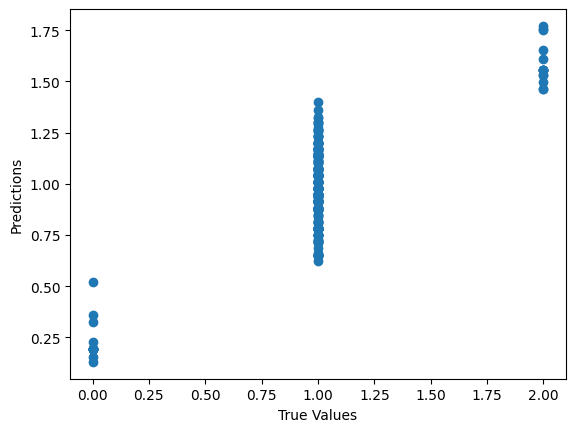

In [280]:
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score", model.score(X_test, y_test))

As we can see, the data is accurately being clustered into three different subgroups, one for true supplements "0", another for meal replacements "1", and one for increased metabolic demand "2". However, we can also see that our custom model performed better, as it has a superior accuracy score by almost 30%. Nevertheless, the model is still lacking due to poor data input.

However, we can still test out for learning purposes how other optimizations improve the model. Let's try BGFS Hessian approximations, and see what happens.

In [281]:
# also based on Dr. Larson's notebook on Optimization
from scipy.optimize import fmin_bfgs # maybe the most common bfgs algorithm in the world
from numpy import ma
class BFGSLogisticRegression(ClassifyLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0])) + C*sum(w**2) 
        #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))
            
bfgslr = BFGSLogisticRegression(_,iterations=2,C=0.001) # note that we need only a few iterations here

class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, 
                 C=0.0001, 
                 solver=BFGSLogisticRegression):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = np.array(y==yval).astype(int) # create a binary problem
            # train the binary classifier for this class
            
            hblr = self.solver(eta=self.eta,iterations=self.iters,C=self.C)
            hblr.fit(X,y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    
lr = MultiClassLogisticRegression(eta=1,
    iterations=10,
    C=0.01,
    solver=BFGSLogisticRegression
    )
lr.fit(X_train,y_train)
print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

MultiClass Logistic Regression Object with coefficients:
[[ 1.39794311 -0.43094634  0.12513884]
 [-1.42571699  0.00381683  0.08001956]
 [-2.43482383  0.22350073 -0.2091847 ]]
Accuracy of:  0.9359430604982206


Wow! That actually gave us some really good accuracy! The model seems like it's working better thanks to the complex mathematics introduced by Quasi-Newton optimization. However, I still do not feel comfortable with the results, as I understand they are based on poor data. Nevertheless, we can now see that long-handed approaches with complex optimizations work better than generic libraries like SciPy.

## Deployment

After developing two custom model and comparing it to sklearn, it is unadvisable to deploy either. Despite the higher performance of the custom model, the data is incomplete, muddled, and needs extensive cleaning. Furthermore, out target is directly based on our quantitative values, and the output would simply be a matter of encoding. Better data would be required to deploy a commercially viable model that could actually recommend products to people. As it stands, models based on this data are doomed to fail and should not be used predict an actual person's health needs.